<H1><CENTER> Machine Learning Lab - Exercise Sheet 10 <br /></CENTER></H1>
<H2><CENTER> Author: Sebastian Pineda Arango  <br />
ID: 246098<br />
Universität Hildesheim - Data Analytics Master </CENTER></H2>

<img src="https://www.uni-hildesheim.de/typo3conf/ext/unihildesheim/Resources/Public/Images/logo-uni.svgz" width="100">


## Exercise 1

In this exercise we want to aply clusterin methods to two differente datasets:

- Dataset 1: Iris dataset (in sparse format) https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale

- Dataset 2: 20 news dataset: http://qwone.com/~jason/20Newsgroups/

Firstly, we want to cluster Iris dataset. The dataset is well-known tdataset, with four features, 150 samples and three classes. However, in this case we are going to neglect the classes, since we want to work only in an unsupervised way.

#### Step 1: Importing libraries

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file

%matplotlib inline

#### Step 2: Reading file

The file is in sparse format, however the function load_svm_light_file returns the design matrix and the label vectors. We also transform the returned design matrix (which is in sparse compressed format) to dense matrix.

In [2]:
#Reading file
data = load_svmlight_file("iris.scale.txt")
X = data[0]
y = data[1]

#transforming to dense matrix
X_dense = X.todense()

#### Step 3: Implementing K-Means algorithm

To implement k-means algorhtm, four functions are defined:

- find_assignation: to find the cluster to which each sample belongs to.
- find_center: to update the center after and assignation step
- find_MSE: to evaluate the clustering


In [3]:
def find_assignation(X,C):
    
    '''Finds the cluster represented by centers in C to which each 
       sample of X belongs. Returns the number of the cluster for 
       each sample.'''
    
    assignation=[]
    for i in range(X.shape[0]):
        
        #Look for the closes center for each data point
        assignation.append(np.argmin(np.linalg.norm(X[i,]-C,axis=1)))

    return assignation

def find_center(X, assignation, k):
    
    '''Returns the new centers according to the assignation. '''
    
    d = X.shape[1]
    C = np.zeros([k, d])
    
    for i in list(set(assignation)):
        
        #calculate the new center with assgination index given by i
        C[i,:] = X[np.array(assignation)==i,:].mean(axis=0)
    
    return C

def find_MSE(X,C,assignation):
    
    '''Returns the RMSE for a given clustering configuration: (data and centers)'''
    
    q = []
    
    for i, a in enumerate(assignation):
        q.append(np.linalg.norm(X[i,]-C[a,])**2)
    
    return np.mean(q)


def K_means(X, k, max_iter = 50):
    
    '''Performs K-Means clustering, where K is the number of cluster to return'''

    #Initialization of variables
    d = X.shape[1] #dimension of the problem
    C= np.random.random((k,d)) #random centers initialization
    MSE_list = []
    
    #First run of assignation 
    assignation = find_assignation(X,C)
    MSE = find_MSE(X, C, assignation)
    MSE_list.append(MSE)

    for i in range(4):

        #updating centers
        C = find_center(X, assignation, k)
        
        #assignation of data to cluster accordint to centers
        assignation = find_assignation(X,C)
        
        #computing RMSE
        last_MSE = MSE
        MSE = find_MSE(X, C, assignation)
        
        #saving data for plotting
        MSE_list.append(MSE)
        
        #convergence criterion: if MSE change is small
        if(np.abs(last_MSE-MSE)<0.0001):
            break

            
    return C, np.array(assignation), MSE_list
    

#### Step 4: Evaluating the performance of the algorithm

Evaluating the clustering is a though task, since no data classes are given a priori. Therefore, some methodologies and heuristics have been developed to assess the quality of the clustering. Maybe, one of the most well known is the elbow criteria, which states that the number of cluster should be located near to the point where the curve RMSE vs. Number of clusters change a lot. A reinterpretation of that is: where the second derivative is maximal.

Another criteria is also the index Silhouette. This index aims to minimize the intracluster distance (distance between points of the same cluster) and, at the same time, to maximize the intercluster distance (distance between clusters centers) [2].

The silhouette index for a sample i is given by:

$s(i) = \frac{b(i)-a(i)}{max\{a(i),b(i)\}}$

The silhouette index  of a clustering setting is therefore the mean of the cluster indeces of the individual samples.

In [17]:
def silhouette(X, A, k):
    
    '''This function evaluates the silhouette index for a dataset X, given
    an assignation A (this includes information of clustering).'''
    
    print("Trying k=",k)
    sil= []
    for i in range(X.shape[0]):
        dist_to_k = []
        for k_i in range(k):
            
            dist= np.mean(np.linalg.norm(X[i,]-X[A==k_i,], axis=1))
            
            if(k_i == A[i]):
                a = dist
            else:
                dist_to_k.append(dist)
                
        m_min = min(dist_to_k)
        sil_x = (m_min-a)/max((a, m_min))
        sil.append(sil_x)
        
    return np.mean(sil)
    

def find_K_with_silhouette (X, max_k):
    
    '''This function iterates over a set of K values and pick the k
    with the most apporpiate silhouette index'''
    max_iter=100
    sil_list = []
    for i in range(2,max_k):
        
        #cluster data using k-means
        C, A, MSE_list = K_means(X,i, max_iter)
        
        #find the silhouette index of the clustering
        sil = silhouette(X, A, i)
        
        #append index to indeces list
        sil_list.append(sil)
    
    return sil_list, np.argmax(sil_list)+2

#find best K
max_k = 20
sil_list, best_k = find_K_with_silhouette(X_dense, max_k)
print("The best number of k is", best_k)

Trying k= 2
Trying k= 3
Trying k= 4
Trying k= 5
Trying k= 6
Trying k= 7
Trying k= 8
Trying k= 9
Trying k= 10


C:\Users\User\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trying k= 11
Trying k= 12
Trying k= 13
Trying k= 14
Trying k= 15
Trying k= 16
Trying k= 17
Trying k= 18
Trying k= 19
The best number of k is 2


In [48]:
def find_K_with_derivative(X, max_k):
    
    '''Iterates over different K and pick the one with 
    the highest second derivative (elbow criterion)'''
    
    k_list = list(range(1,max_k))
    MSE_k_list  = []
    max_iter = 100
    
    for k in k_list:
        print("Trying with k=",k)
        C, A, MSE_list = K_means(X, k, max_iter)
        MSE_k_list.append(MSE_list[-1])

    second_derivative = [MSE_k_list[i+1] + MSE_k_list[i-1] - 2 * MSE_k_list[i] for i in range(1,len(MSE_k_list)-1)]
    best_k = np.argmax(second_derivative)+2
    
    return second_derivative, best_k, MSE_k_list

sd, best_k, MSE_list = find_K_with_derivative(X_dense, max_k)

print("Best k for clustering:", best_k)

Trying with k= 1
Trying with k= 2
Trying with k= 3
Trying with k= 4
Trying with k= 5
Trying with k= 6
Trying with k= 7
Trying with k= 8
Trying with k= 9
Trying with k= 10
Trying with k= 11
Trying with k= 12
Trying with k= 13
Trying with k= 14
Trying with k= 15
Trying with k= 16
Trying with k= 17
Trying with k= 18
Trying with k= 19
Best k for clustering: 2


Now we put all the graphs together to pick the cluster size:

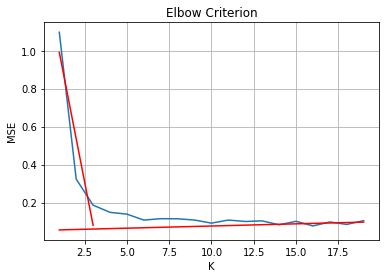

In [40]:
plt.plot(range(1, max_k), MSE_list)
plt.xlabel("K")
plt.ylabel("MSE")
plt.title("Elbow Criterion")

x1 = range(1,4)
y1 = MSE_list[:3]
m1,b1 = np.polyfit(x1, y1, 1) 

x2 = range(max_k-6,max_k)
y2 = MSE_list[-6:]
m2,b2 = np.polyfit(x2, y2, 1) 

x = range(1, max_k)
plt.plot(x, m2*x+b2, 'red')
plt.plot(x1, m1*x1+b1, 'red')
plt.grid()

Text(0.5,1,'Silohuette Criterion')

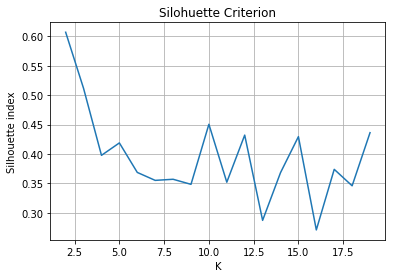

In [46]:
plt.plot(range(2,max_k),sil_list)
plt.grid()
plt.xlabel("K")
plt.ylabel("Silhouette index")
plt.title("Silohuette Criterion")

Text(0,0.5,'Derivative')

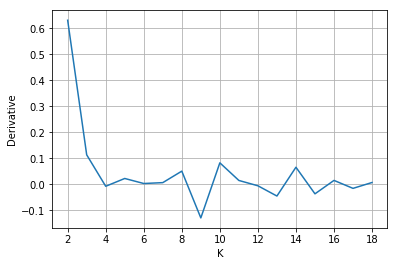

In [56]:
plt.plot(range(2,max_k-1), sd)
plt.grid()
plt.xlabel("K")
plt.ylabel("Derivative")

To get the exact number of optimal cluster is nearly impossible but there criterions somewhat give a closer insight. According to the elbow criterion, the number of cluster should be 3. By referring to second derviative and sihlouette, the decision would be for 2 clusters.

It is, therefore, aceptable to claim that the proper number of cluster is 2. In the following we create  different plots to get an idea of how the data is being clustered along different dimensions. The clusters center are colored with red.Two centers turns to be a reasoable decision.

Text(0,0.5,'Petal width')

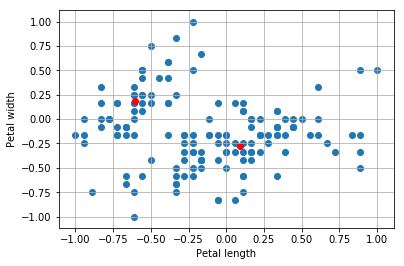

In [57]:
#Graphs 
X= X_dense
k = 2
C, A, MSE_list = K_means(X_dense,k, 120)

plt.scatter(np.array(X[:,0]), np.array(X[:,1]))
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), c= "red")
plt.grid()
plt.xlabel("Petal length")
plt.ylabel("Petal width")

Text(0,0.5,'Sepal width')

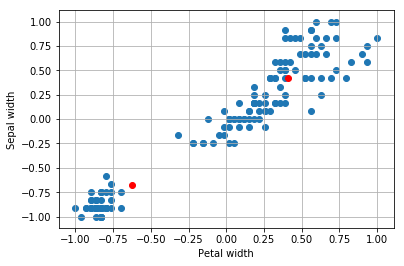

In [61]:
#Graphs 
X= X_dense
k = 2
C, A, MSE_list = K_means(X_dense,k, 120)

plt.scatter(np.array(X[:,2]), np.array(X[:,3]))
plt.scatter(np.array(C[:,2]), np.array(C[:,3]), c= "red")
plt.grid()
plt.xlabel("Petal width")
plt.ylabel("Sepal width")

Text(0,0.5,'Sepal length')

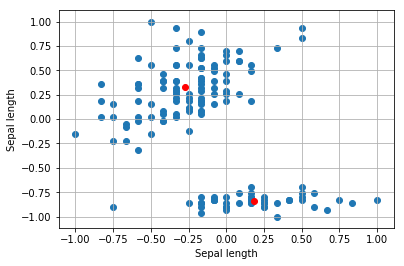

In [62]:
#Graphs 
X= X_dense
k = 2
C, A, MSE_list = K_means(X_dense,k, 120)

plt.scatter(np.array(X[:,1]), np.array(X[:,2]))
plt.scatter(np.array(C[:,1]), np.array(C[:,2]), c= "red")
plt.grid()
plt.xlabel("Sepal length")
plt.ylabel("Sepal length")

# Exercise 2

The second dataset consist in a set of news which belongs to 20 different topics. However, in this clustering task, we won't use the label. The main objective, then, is to perform cluster analysis and to find the best possible K for this data set.

#### Step 1: Readin dataset

As the dataset are raw texts, we should list them and read them. Then we put it toggether in list to further processing.

In [69]:
#importing library to get data
import os

#path to th data
path_to_train = "20news-bydate/20news-bydate-train"
path_to_test = "20news-bydate/20news-bydate-test"


def read_news(path):
    
    '''Function to read news located in given path folder'''
    
    class_list = []
    text_list = []
    folders = os.listdir(path)

    for folder in folders:
        files = os.listdir(path+"/"+folder)

        print("Reading", folder, "folder")

        for file_name in files:
            file = open(path+"/"+folder+"/"+file_name, 'r')
            text = file.read()

            class_list.append(folder)
            text_list.append(text)

    data = pd.DataFrame({'Text': text_list,
                        'Label': class_list})

    return data

print("Gathering all news data...")
train_news = read_news(path_to_train)
test_news = read_news(path_to_test)

print("Shape of training set:", train_news.shape)
print("Shape of test set:", test_news.shape)

Gathering all news data...
Reading alt.atheism folder
Reading comp.graphics folder
Reading comp.os.ms-windows.misc folder
Reading comp.sys.ibm.pc.hardware folder
Reading comp.sys.mac.hardware folder
Reading comp.windows.x folder
Reading misc.forsale folder
Reading rec.autos folder
Reading rec.motorcycles folder
Reading rec.sport.baseball folder
Reading rec.sport.hockey folder
Reading sci.crypt folder
Reading sci.electronics folder
Reading sci.med folder
Reading sci.space folder
Reading soc.religion.christian folder
Reading talk.politics.guns folder
Reading talk.politics.mideast folder
Reading talk.politics.misc folder
Reading talk.religion.misc folder
Reading alt.atheism folder
Reading comp.graphics folder
Reading comp.os.ms-windows.misc folder
Reading comp.sys.ibm.pc.hardware folder
Reading comp.sys.mac.hardware folder
Reading comp.windows.x folder
Reading misc.forsale folder
Reading rec.autos folder
Reading rec.motorcycles folder
Reading rec.sport.baseball folder
Reading rec.sport.ho

#### Step 2: Preprocessing of text

After reading the text, we process it using regular expression in oder to eliminate non-alpahnumeric characters and common stop words.

In [70]:
from stop_words import  get_stop_words
import re

def preprocess_text (x, stop_words):
    
    '''This function preprocess a string, eliminateing sop words and
    non-alphanumeric characters.'''
    
    x = x.lower()
    x = re.sub(r'[^\w\s]','',x)
    x = re.sub(r'[0-9]','',x)
    x = re.sub(r'\n','',x)
    
    for stop_word in stop_words:
        x = re.sub(r' '+stop_word+' ',' ', x)
    
    return x

In [72]:
en_stop = get_stop_words('en')

print("Preprocessing data... ")
train_news.Text = train_news.Text.apply(lambda x: preprocess_text(x, en_stop))
test_news.Text = test_news.Text.apply(lambda x: preprocess_text(x, en_stop))
print("Preprocessing finished... ")

Preprocessing data... 
Preprocessing finished... 


We separate the design matrix (X) from the label vector (y) for training and test.

In [74]:
#saving in libsvm format
train_news.to_csv("train_news.csv", sep ="\t")
test_news.to_csv("test_news.csv", sep="\t")

#separating features and labels
X_train = train_news.Text
y_train = train_news.Label

X_test = test_news.Text
y_test = test_news.Label

#### Step 3: Transforming data

We want now to convert the data to numeric format so that we can use it in a given model. We first tried count vectorizer, but we see that the number of dimensions turns out to be very high. So we use a Doc2Vec model, to embed the documents in fewer dimensions. We also standarize data.

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

#getting the frequency of terms
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print("Design matrix for training has following dimensions:", X_train_counts.shape)

X_test_counts = count_vect.transform(X_test)
print("Design matrix for training has following dimensions:", X_test_counts.shape)

Design matrix for training has following dimensions: (11314, 209498)
Design matrix for training has following dimensions: (7532, 209498)


In [76]:
#importing Doc2Vec library
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

d = 30 #dimensions to embeded

#creating the list of words (one word for each sentence)
lists_of_words = [x.split(" ") for x in X_train]

#create documents to create embedding model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(lists_of_words)]
model = Doc2Vec(documents, vector_size=d, window=2, min_count=1)

#transforming the data 
embedding = np.zeros((len(lists_of_words),d))
for i in range(embedding.shape[0]):
    embedding[i, ] =model.infer_vector(lists_of_words[i])



In [78]:
#standarizing data
from sklearn.preprocessing import StandardScaler

X_transformed = embedding
scaler = StandardScaler()
X_tr2 = scaler.fit_transform(X_transformed)

#### Step 4: Choosing the best k

As before, using the K-Means for Iris dataset, we try different criteria to get the best K.

In [104]:
max_k = 20
sd, best_k, MSE_list = find_K_with_derivative(X_tr2, max_k)
print("Best k according to derivatives:",best_k)

Trying with k= 1
Trying with k= 2
Trying with k= 3
Trying with k= 4
Trying with k= 5
Trying with k= 6
Trying with k= 7
Trying with k= 8
Trying with k= 9
Trying with k= 10
Trying with k= 11
Trying with k= 12
Trying with k= 13
Trying with k= 14
Trying with k= 15
Trying with k= 16
Trying with k= 17
Trying with k= 18
Trying with k= 19
Best k according to derivatives: 2


Text(0.5,1,'Change of MSE with the number of clusters')

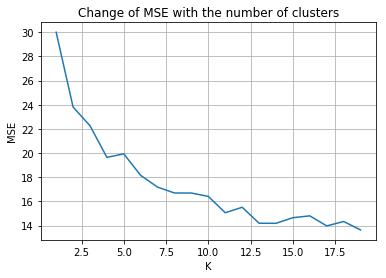

In [105]:
plt.plot(range(1, max_k), MSE_list)
plt.xlabel("K")
plt.ylabel("MSE")
plt.grid()
plt.title("Change of MSE with the number of clusters")

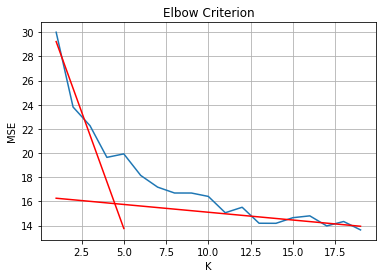

In [108]:
plt.plot(range(1, max_k), MSE_list)
plt.xlabel("K")
plt.ylabel("MSE")
plt.title("Elbow Criterion")

x1 = range(1,4)
y1 = MSE_list[:3]
m1,b1 = np.polyfit(x1, y1, 1) 

x2 = range(max_k-6,max_k)
y2 = MSE_list[-6:]
m2,b2 = np.polyfit(x2, y2, 1) 

x = range(1, max_k)
plt.plot(x, m2*x+b2, 'red')
plt.plot(x[:5], m1*x[:5]+b1, 'red')
plt.grid()

Text(0.5,1,'Derivative criterion')

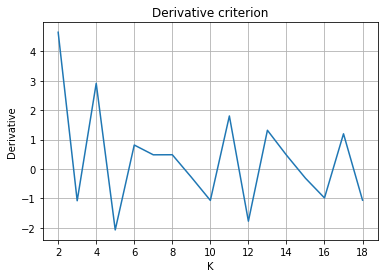

In [109]:
plt.plot(range(2,max_k-1), sd)
plt.grid()
plt.xlabel("K")
plt.ylabel("Derivative")
plt.title("Derivative criterion")

We also apply silhouette cristerion to get the best K. However, since Silhouette criterion is too complex to calculate, we use a subset of the data.

In [110]:
X = X_tr2
max_k=10

sil_list = []

for i in range(2,max_k):
    C, A, MSE_list = K_means(X,i, 100)
    idx = np.random.randint(0,X.shape[0],2000) 
    sil = silhouette(X[idx,], A[idx,], i)
    sil_list.append(sil)

Trying k= 2
Trying k= 3
Trying k= 4
Trying k= 5
Trying k= 6
Trying k= 7
Trying k= 8
Trying k= 9


Text(0.5,1,'Silouette criterion')

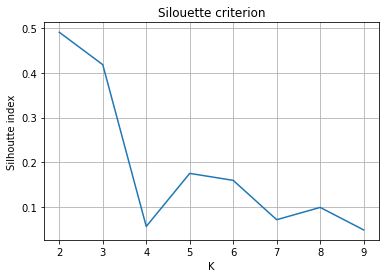

In [148]:
plt.plot(range(2, max_k),sil_list)
plt.grid()
plt.xlabel("K")
plt.ylabel("Silhoutte index")
plt.title("Silouette criterion")

#### Step 5: Interpreting results

According to the different plots (and the elbow criterion) the best k is between three and four. The silhouette index for k=2 and k=3 is high, whereas the derivative for  k=2 and k = 4 is also high. The elbow criterion show that the "elbow" could approximately be find in 4.

We want now to see how many train samples of each new type fall into each cluster, so that we can interpretate the cluster as identifying a news class.
After creating cross tabulations of the distribution of samples given a cluster and a type of new, we see that is somewhat difficult to differentiate clearly each cluster class. It means indeed, that the classes are not so easily separable with spherical clusters.

In [120]:
#interpreting clustering with 3 centers
C, A, MSE_list = K_means(X_tr2,3, 1000)

pd.crosstab(y_train, A)

col_0,0,1,2
Label,,,
alt.atheism,3,374,103
comp.graphics,50,519,15
comp.os.ms-windows.misc,52,531,8
comp.sys.ibm.pc.hardware,37,550,3
comp.sys.mac.hardware,23,546,9
comp.windows.x,108,474,11
misc.forsale,43,519,23
rec.autos,5,517,72
rec.motorcycles,3,521,74


In [117]:
#interpreting clustering with 4 centers
C, A, MSE_list = K_means(X_tr2,4, 1000)

pd.crosstab(y_train, A)

col_0,0,1,2,3
Label,,,,
alt.atheism,137,93,245,5
comp.graphics,445,11,114,14
comp.os.ms-windows.misc,509,3,70,9
comp.sys.ibm.pc.hardware,510,3,72,5
comp.sys.mac.hardware,442,8,127,1
comp.windows.x,426,9,141,17
misc.forsale,442,17,119,7
rec.autos,237,56,298,3
rec.motorcycles,229,52,315,2


We also want to compare how it performs in test data.

In [121]:
#transforming test data
lists_of_words = [x.split(" ") for x in X_test]

#embedding test data
embedding = np.zeros((len(lists_of_words),d))
for i in range(embedding.shape[0]):
    embedding[i, ] =model.infer_vector(lists_of_words[i])

X_test_tr = embedding
X_test_tr2 = scaler.fit_transform(X_test_tr)

In [137]:
C, A, MSE_list = K_means(X_tr2,4, 1000)

assignation = find_assignation(X_test_tr2, C)
MSE_test = find_MSE(X_test_tr2, C, assignation)

print("Train MSE:", MSE_list[-1])
print("Test MSE:", MSE_test)

Train MSE: 18.7925189411
Test MSE: 19.9126719911


We can see that, in fact, the MSE for test is very close to the MSE of train. It is reasonable, since both data come from the same distribution, therefore the clustering of a train set should be valid for new data sampled from the same distribution. However, this result also shows that we didn't overfit the data. As K increase, the clustering model gets more complex and more prone to overfit.

#### Step 6: Comparison with Scikit-learn K-Means

We wnat to compare MSE and speed of our implementation with the one of Scikit learn. To make it comparable, we must note that Scikit-learn outputs the inertia, which is the sum of the square distance of samples to the cluster centers.

In [145]:
from sklearn.cluster import KMeans
import numpy as np

n_samples = X_tr2.shape[0]

kmeans = KMeans(n_clusters=4, random_state=0, n_init=1).fit(X_tr2)

print("MSE Scikit-learn:", kmeans.inertia_/n_samples)
print("MSE self implementation:" , MSE_list[-1])

MSE Scikit-learn: 18.5196837336
MSE self implementation: 18.7925189411


We see that both results are very close, what shows that both implementations are funcional comparable. But, what happen with the execution speed? We want to measure it now.

In [147]:
import time

start_sk = time.time()
kmeans = KMeans(n_clusters=20, random_state=2, n_init=1).fit(X_tr2)
end_sk = time.time()

print("Time Elapsed with Scikit-Learn:", end_sk-start_sk)

start_m = time.time()
C, A, MSE_list = K_means(X_tr2, 20, 100)
end_m = time.time()

print("Time Elapsed with self implementation:",end_m - start_m)

Time Elapsed with Scikit-Learn: 0.40576720237731934
Time Elapsed with self implementation: 1.5191280841827393


For scikit-learn, we execute with the parameter n_init=1, since the function runs K-Mean several times to get the lower MSE (to avoid possible local minima). This, therefore, affect computation time. The times are scale comparable, however, the scikit learn implementation is three times faster than our implementations. This is due to the possible optimizations that they do computing the centers or assignations, which we did not approach here.

## References

[1] Elbow criterion: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

[2] Silhouette index paper: https://pdfs.semanticscholar.org/f168/41e022038e94a59f7e0a82002102b78d79a4.pdf